In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
matplotlib.rcParams['font.size'] = 12

import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


According to [Newton+2019](https://arxiv.org/pdf/1906.10703.pdf), age of TOI200/DS Tuc A ~45 Myr.

In [2]:
#search by toiid
toiid=1063
t = cr.Star(toiid=toiid)
t.target_coord #note distance is also known for TOIs

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (230.5555, -83.05621389, 61.1201)>

## age using rotation period

Available sectors: [12, 13]
Using sector=12.
Searching lightcurvefile for TIC 406976746 (sector 12)


Could not resolve TIC 406976746 to a sky position.
ERROR:lightkurve.search:Could not resolve TIC 406976746 to a sky position.


Searching lightcurvefile for 230.555 -83.0562 (sector 12)
Searching lightcurvefile for TIC 406976746 (sector 13)


Could not resolve TIC 406976746 to a sky position.
ERROR:lightkurve.search:Could not resolve TIC 406976746 to a sky position.


Searching lightcurvefile for 230.555 -83.0562 (sector 13)


Text(0.5, 1.0, 'TIC 406976746 (sector 12, 13)')

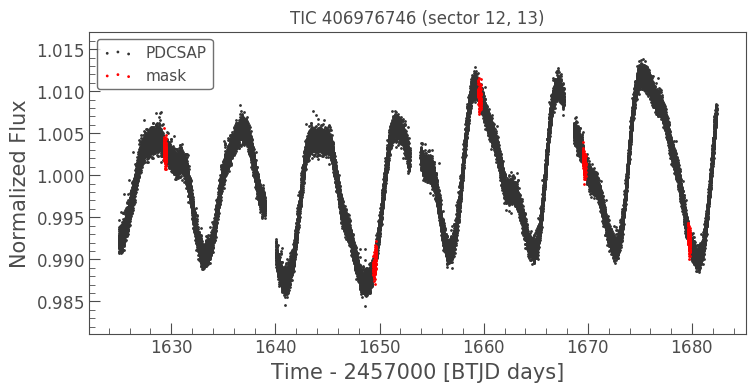

In [3]:
s = cr.ShortCadence(toiid=toiid)
lc1 = s.get_lc(lctype='pdcsap', sector=12)
tmask1 = cr.get_transit_mask(lc1,
                            period=s.toi_period,
                            t0=s.toi_epoch-cr.utils.TESS_TIME_OFFSET,
                            t14_hours=s.toi_duration
                            )

lc2 = s.get_lc(lctype='pdcsap', sector=13)
tmask2 = cr.get_transit_mask(lc2,
                            period=s.toi_period,
                            t0=s.toi_epoch-cr.utils.TESS_TIME_OFFSET,
                            t14_hours=s.toi_duration
                            )
lc = lc1[~tmask1].append(lc2[~tmask2])
lcm = lc1[tmask1].append(lc2[tmask2])
# tmask = [j for sub in [tmask1,tmask2] for j in sub]

ax = lc.scatter(label='PDCSAP')
lcm.scatter(ax=ax, label='mask', c='r')
ax.set_title(f'TIC {s.ticid} (sector 12, 13)')

Text(0.5, 0.98, 'TIC 406976746 (sector 12, 13)')

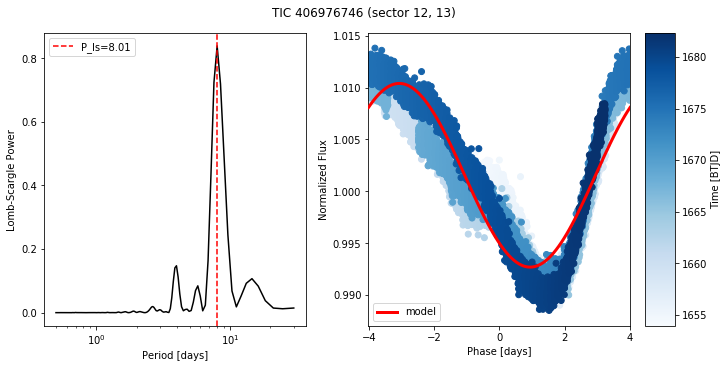

In [4]:
lc = s.lc_pdcsap.remove_outliers().normalize()
fig = cr.plot_lomb_scargle(lc.time, lc.flux)
fig.suptitle(f'TIC {s.ticid} (sector 12, 13)')

P=8.18+/-0.82 d


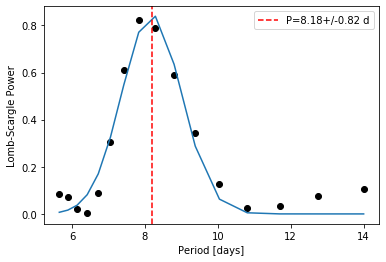

In [5]:
prot, prot_err = cr.get_rotation_period(lc, npoints=10, plot=True)

In [6]:
#get age results
age,age_plus,age_minus,samples = t.get_age(method='prot', prot=(prot,prot_err), return_samples=True)

Querying Gaia DR2 catalog for 230.555 -83.0562 within 2.0 arcsec.

Querying TIC catalog for 230.555 -83.0562
            within 2.0 arcsec.

Gaia and TIC catalog cross-match succeeded.
Estimating age using gyrochronology

gyro age = 508.82 + 117.69 - 84.38 Myr using rotation period 0.82, 0.82


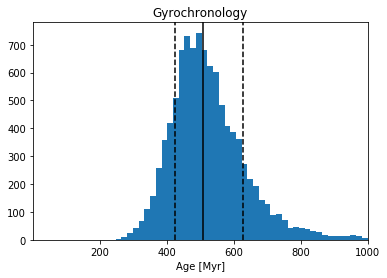

In [7]:
pl.hist(samples/1e6, bins=300);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Gyrochronology')
pl.xlabel('Age [Myr]')
pl.xlim(1,1e3);

## age using rotation amplitude

In [8]:
prot, prot_err

(8.182473772245213, 0.8160483861865964)

gyro age = 92.18 + 173.04 - 81.54 Myr using rotation amplitude 1.861,0.337


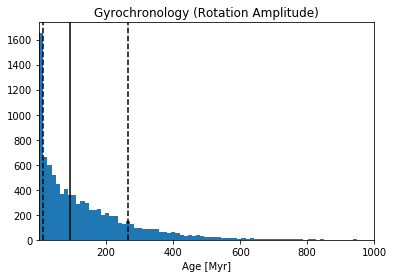

In [12]:
#get age results
age,age_plus,age_minus,samples = t.get_age(lc, prot=(prot,prot_err), method='amp', return_samples=True)

pl.hist(samples/1e6, bins=300);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Gyrochronology (Rotation Amplitude)')
pl.xlabel('Age [Myr]')
pl.xlim(1,1e3);

## age using gyrochronology+isochrones

### with JHK

In [11]:
#spectroscopic constraints from SMARTS/CHIRON
teff = (5332,100) 
logg = (4.56, 0.05)
feh = (-0.09, 0.05)

In [12]:
t.get_iso_params(teff=teff,
                logg=logg,
                feh=feh,
                add_jhk=True
              )

Gaia and TIC catalog cross-match succeeded.


{'teff': [5332.0, 100.0],
 'G': [9.588498, 0.01],
 'bp': [10.0314417, 0.01],
 'rp': [9.027062, 0.01],
 'parallax': [16.332310962617218, 0.1035314124863975],
 'feh': [-0.09, 0.05],
 'logg': [4.56, 0.05],
 'J': [8.352, 0.027],
 'H': [7.997, 0.036],
 'K': [7.858, 0.036]}

In [13]:
star = t.run_stardate(prot=(prot,prot_err), 
                      mcmc_steps=10000
                     )

Estimating age using isochrones+gyrochronology

Input parameters:
{'Av': [0.34590287134051323, 0.01],
 'G': [9.588498, 0.01],
 'H': [7.997, 0.036],
 'J': [8.352, 0.027],
 'K': [7.858, 0.036],
 'bp': [10.0314417, 0.01],
 'feh': [-0.09, 0.05],
 'logg': [4.56, 0.05],
 'parallax': [16.332310962617218, 0.1035314124863975],
 'rp': [9.027062, 0.01],
 'teff': [5332.0, 100.0]}
Init parameters:
{'Av': 0.0045,
 'EEP': 329.58,
 '[Fe/H]': -0.0478,
 'ln(Distance)': 5.560681631015528,
 'log10(Age [yr])': 9.5596}
emcee: Exception while calling your likelihood function:
  params: [ 3.29580126e+02  9.55947681e+00 -4.78216663e-02  1.71558412e+00
  4.66157677e-03]
  args: [<isochrones.starmodel.SingleStarModel object at 0x7fef00762f50>, 8.182473772245213, 0.8160483861865964, False, False, True, 'praesepe']
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/emcee/ensemble.py", line 495, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/stardate/lhf.py", line 431, in lnprob
    lnpr = mod.lnprior(params)
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/isochrones/starmodel.py", line 1547, in lnprior
    feh=pars[self.feh_index])
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/isochrones/priors.py", line 129, in lnpdf
    pdf = self.pdf(x, **kwargs)
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/isochrones/priors.py", line 53, in pdf
    return self._pdf(x, **kwargs) / self._norm
  File "/home/jp/miniconda3/envs/py3/lib/python3.7/site-packages/isochrones/priors.py", line 409, in _pdf
    orig_val, dx_deep = self.ic.interp_value(pars, [self.orig_par, self.deriv_prop]).squeeze()
  File "/home/jp/miniconda3/envs/py3/lib/p

KeyboardInterrupt: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: processing IR)


In [ ]:
fig = t.plot_flatchain();

In [ ]:
#get age results
burnin=6000
age,age_plus,age_minus,samples = t.get_age(method='isochrones', return_samples=True, burnin=burnin)

In [ ]:
pl.hist(samples/1e6, bins=100);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Isochrones+Gyrochronology')
pl.xlabel('Age [Myr]')
pl.xlim(1,5e3);

In [ ]:
fig = t.plot_corner(burnin=burnin)

### without JHK

In [ ]:
t.get_iso_params(teff=teff,
                logg=logg,
                feh=feh,
                add_jhk=False
                )

In [ ]:
t.iso_params

In [ ]:
#first run stardate
star = t.run_stardate(prot=(prot,prot_err), mcmc_steps=10000)

In [ ]:
fig = t.plot_flatchain();

In [ ]:
#get age results
burnin=6000
age,age_plus,age_minus,samples = t.get_age(method='isochrones', return_samples=True, burnin=burnin)

In [ ]:
pl.hist(samples/1e6, bins=100);
pl.axvline((age+age_plus)/1e6, 0, 1, ls='--', c='k')
pl.axvline(age/1e6, 0, 1, ls='-', c='k')
pl.axvline((age-age_minus)/1e6, 0, 1, ls='--', c='k')
pl.title('Isochrones+Gyrochronology')
pl.xlabel('Age [Myr]')
pl.xlim(1,5e3);

In [ ]:
fig = t.plot_corner(burnin=burnin)